# Host Decoder examples

In this notebook we will show examples of different implementations of Host Decoder

## Common code

In [23]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

image_dir = "images"
batch_size = 8

## Host decoder

Decodes whole image

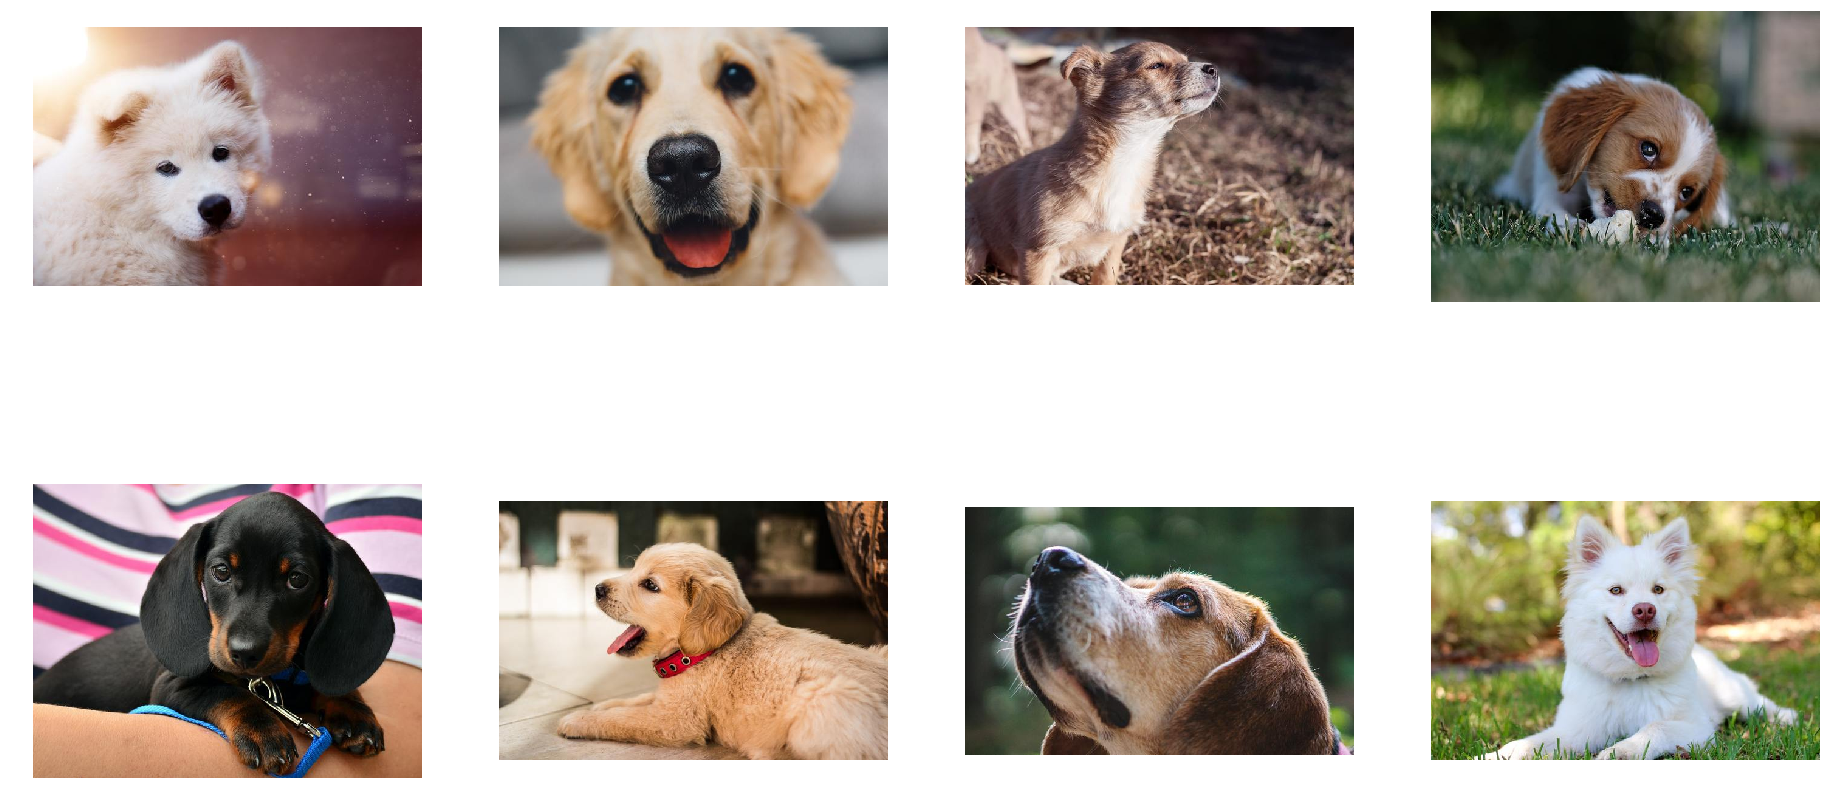

In [26]:
class HostDecoderPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HostDecoderPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.HostDecoder(output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = HostDecoderPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Host Decoder with random cropping window size and anchor

Decodes part of the image by choosing a random aspect ratio and normalized area

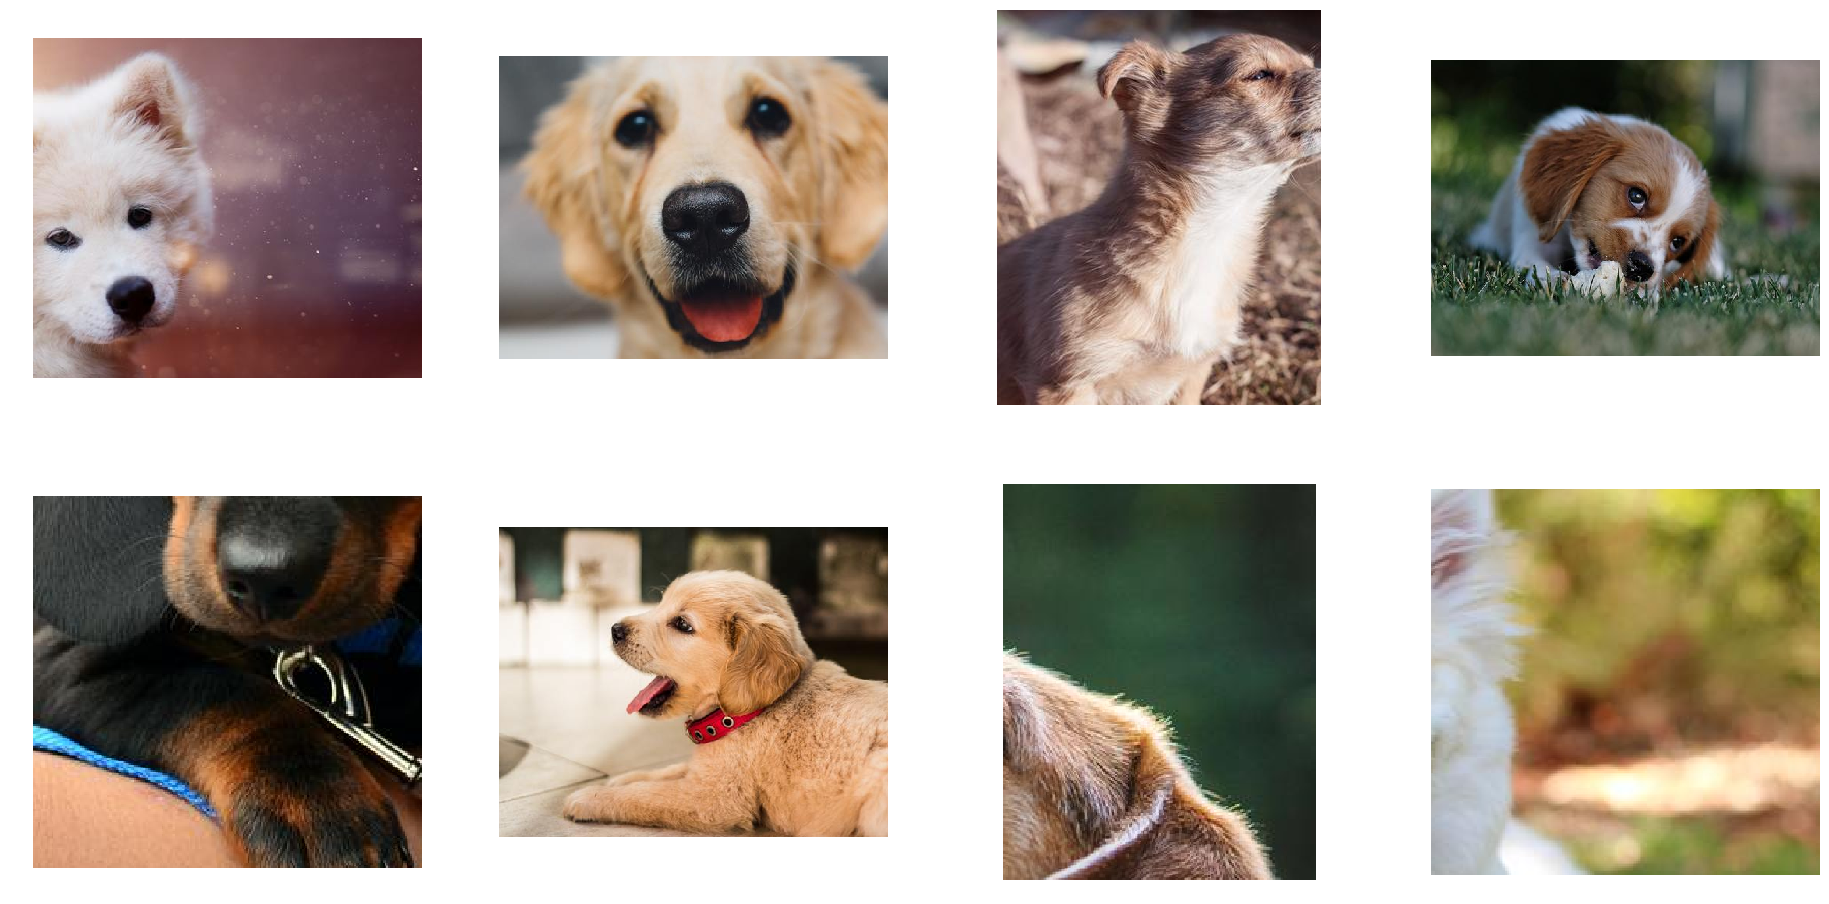

In [30]:
class HostDecoderRandomCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HostDecoderRandomCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.HostDecoderRandomCrop(output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = HostDecoderRandomCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Host Decoder with fixed cropping window size and external anchor

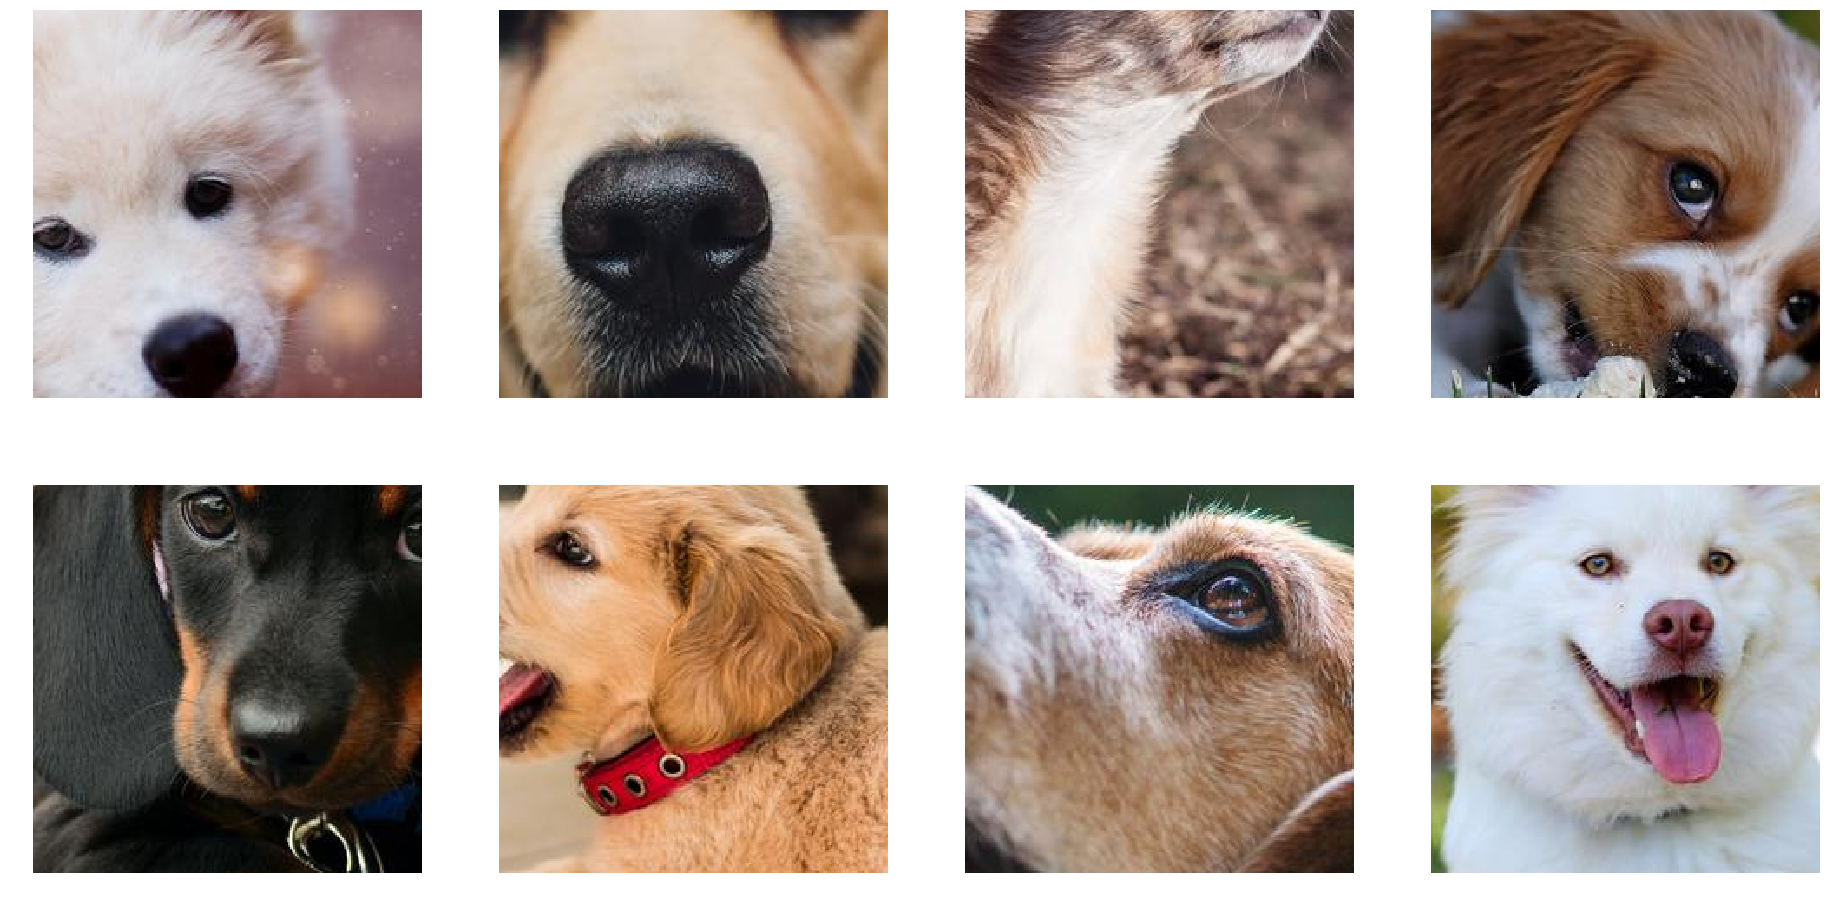

In [33]:
class HostDecoderFixedCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HostDecoderFixedCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.HostDecoderFixedCrop(output_type = types.RGB, crop = (224, 224))

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = HostDecoderFixedCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Host Decoder with external window size and anchor

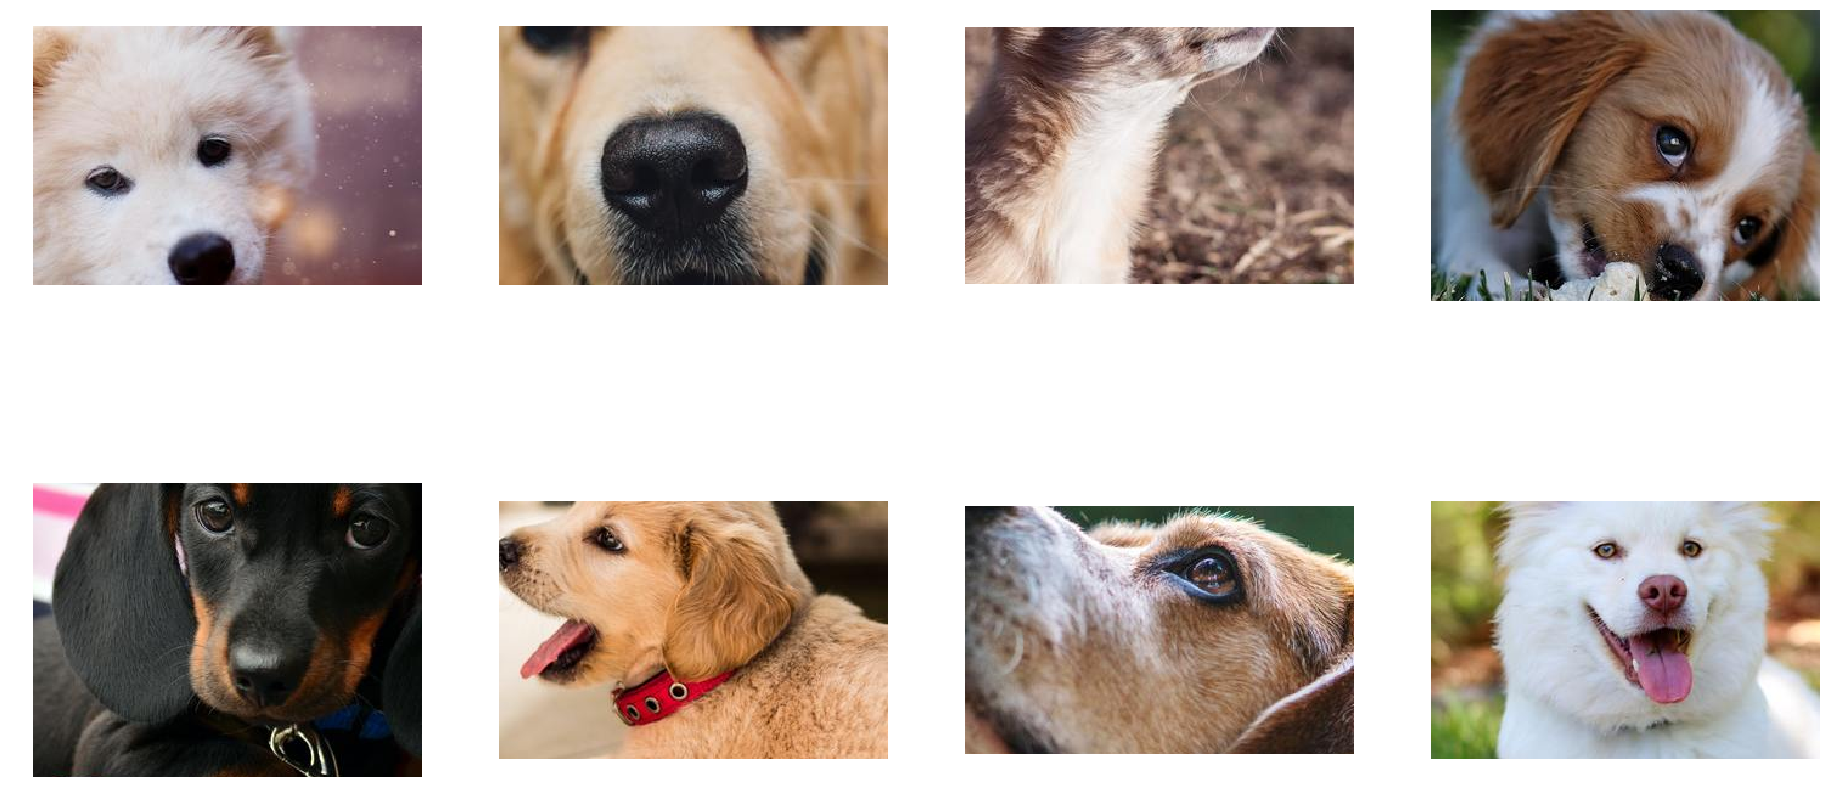

In [36]:
import numpy as np

class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
    def __iter__(self):
        self.i = 0
        self.n = self.batch_size
        return self

    def __next__(self):
        pos = []
        size = []
        for _ in range(self.batch_size):
            pos.append(np.asarray([0.25, 0.25], dtype=np.float32))
            size.append(np.asarray([0.5, 0.5], dtype=np.float32))
            self.i = (self.i + 1) % self.n
        return (pos, size)
    
    next = __next__

eii = ExternalInputIterator(batch_size)
pos_size_iter = iter(eii)
    
class HostDecoderExternalCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HostDecoderExternalCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)

        self.input = ops.FileReader(file_root = image_dir)
        self.input_crop_pos = ops.ExternalSource()
        self.input_crop_size = ops.ExternalSource()
        self.input_crop = ops.ExternalSource()
        self.decode = ops.HostDecoderExternalCrop(output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        self.crop_pos = self.input_crop_pos()
        self.crop_size = self.input_crop_size()
        images = self.decode(jpegs, self.crop_pos, self.crop_size)
        return (images, labels)
    
    def iter_setup(self):
        (crop_pos, crop_size) = pos_size_iter.next()
        self.feed_input(self.crop_pos, crop_pos)
        self.feed_input(self.crop_size, crop_size)
    
pipe = HostDecoderExternalCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )